In [1]:
# Qiskit module
from qiskit import QuantumCircuit, transpile
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for noisy simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.utils import insert_noise

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np
from osp.graph_state import GraphStateDense, GraphState
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')



/home/siyuan/Seafile/Thesis/PycharmProjects/open-science-prize/venv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


          ┌───┐┌───┐                    
q_0: ─────┤ X ├┤ H ├────────────────────
     ┌───┐└─┬─┘├───┤┌───┐┌───┐          
q_1: ┤ H ├──■──┤ H ├┤ X ├┤ H ├──■───────
     └───┘     └───┘└─┬─┘└───┘┌─┴─┐┌───┐
q_2: ─────────────────┼───────┤ X ├┤ H ├
          ┌───┐┌───┐  │       └───┘└───┘
q_3: ─────┤ X ├┤ H ├──■─────────────────
          └─┬─┘└───┘          ┌───┐┌───┐
q_4: ───────┼─────────────────┤ X ├┤ H ├
     ┌───┐  │  ┌───┐┌───┐┌───┐└─┬─┘└───┘
q_5: ┤ H ├──■──┤ H ├┤ X ├┤ H ├──■───────
     ├───┤     └───┘└─┬─┘└───┘          
q_6: ┤ H ├────────────■─────────────────
     └───┘                              
17


In [2]:
from qiskit import IBMQ
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-france', group='univ-montpellier', project='reservations')
backend = provider.get_backend('ibmq_casablanca')
properties = backend.properties()



ibmqfactory.load_account:WARNING:2021-03-24 08:21:34,171: Credentials are already in use. The existing account in the session will be replaced.


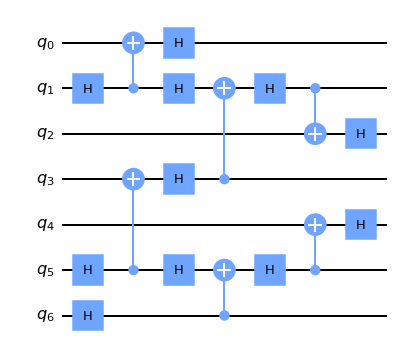

In [3]:
state_circuit = GraphStateDense(backend)
state_circuit.draw(output='mpl')


In [4]:
def compute_stabilizer_group(circuit):
    """Compute the stabilizer group for stabilizer circuit."""
    state = qi.Statevector.from_instruction(circuit)
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        # Why only {-1, 0, 1} are possible values?
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement circuits.

    Args:
        stabilizer (str): a stabilizer string
        initial_circuit (QuantumCircuit): Optional, the initial circuit.

    Returns:
        QuantumCircuit: the circuit with stabilizer measurements.
    """
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ



In [5]:
#generators = qi.Clifford(state_circuit).stabilizer.pauli.to_labels()
stabilizers = compute_stabilizer_group(state_circuit)
print('Stabilizers:', stabilizers)
#print('Generators:', generators)


Stabilizers: ['+IIIIIII', '+IIIIIZX', '+IIIIXIX', '+IIIIXZI', '-IIIZYXY', '+IIIZYYZ', '+IIIZZXZ', '+IIIZZYY', '+IIXXIIX', '+IIXXIZI', '+IIXXXII', '+IIXXXZX', '-IIXYYXZ', '-IIXYYYY', '-IIXYZXY', '+IIXYZYZ', '+IZIXIIX', '+IZIXIZI', '+IZIXXII', '+IZIXXZX', '-IZIYYXZ', '-IZIYYYY', '-IZIYZXY', '+IZIYZYZ', '+IZXIIII', '+IZXIIZX', '+IZXIXIX', '+IZXIXZI', '-IZXZYXY', '+IZXZYYZ', '+IZXZZXZ', '+IZXZZYY', '+XIIXIIX', '+XIIXIZI', '+XIIXXII', '+XIIXXZX', '-XIIYYXZ', '-XIIYYYY', '-XIIYZXY', '+XIIYZYZ', '+XIXIIII', '+XIXIIZX', '+XIXIXIX', '+XIXIXZI', '-XIXZYXY', '+XIXZYYZ', '+XIXZZXZ', '+XIXZZYY', '+XZIIIII', '+XZIIIZX', '+XZIIXIX', '+XZIIXZI', '-XZIZYXY', '+XZIZYYZ', '+XZIZZXZ', '+XZIZZYY', '+XZXXIIX', '+XZXXIZI', '+XZXXXII', '+XZXXXZX', '-XZXYYXZ', '-XZXYYYY', '-XZXYZXY', '+XZXYZYZ', '+YXYIYXY', '-YXYIYYZ', '-YXYIZXZ', '-YXYIZYY', '-YXYZIII', '-YXYZIZX', '-YXYZXIX', '-YXYZXZI', '-YXZXYXZ', '-YXZXYYY', '-YXZXZXY', '+YXZXZYZ', '-YXZYIIX', '-YXZYIZI', '-YXZYXII', '-YXZYXZX', '-YYYXYXZ', '-YYYXYYY', '-

In [6]:

## Append the stabilizer measurements to the graph state circuit
stabilizer_circuits = [stabilizer_measure_circuit(stab, state_circuit)
                       for stab in stabilizers]

In [7]:
num_qubits = 7
labels = ['0000000',
          '0000011',
          '0000101', '0000110', # Added
          '0001001', '0001010', '0001100',
          '0010001', '0010010', '0010100', '0011000',
          '0100001', '0100010', '0100100', '0101000', '0110000',
          '1000001', '1000010', '1000100', '1001000', '1010000', '1100000',
          '1111111']
meas_cal_circuits, metadata = mit.expval_meas_mitigator_circuits(num_qubits, labels=labels)



In [8]:
[meas_cal_circuits_full, state_labels] = mit.complete_meas_cal(range(num_qubits))


In [9]:
# backend is already ibmq_casablanca, do not replace it
#backend = QasmSimulator.from_backend(provider.get_backend('ibmq_casablanca'))
backend = provider.get_backend('ibmq_casablanca')



In [10]:
reps = 16



In [11]:
all_jobs = []
all_jobs_mit = []

for ii in range(reps):

    # Run QPT on backend
    shots = 8192
    il = [0,1,2,3,4,5,6]

    job_backend = execute(stabilizer_circuits, backend, shots=shots, initial_layout=il)
    job_mit_backend = execute(meas_cal_circuits, backend, shots=shots, initial_layout=il)
    print('Job IDs ({}/{}): \n measurement calibration: {}\n stabilizer measurements: {}'.format(
        ii+1, reps, job_mit_backend.job_id(), job_backend.job_id()))

    all_jobs.append(job_backend)
    all_jobs_mit.append(job_mit_backend)



Job IDs (1/16): 
 measurement calibration: 605ae8cc2b8d4128326525d0
 stabilizer measurements: 605ae8c96e5296d060821b16
Job IDs (2/16): 
 measurement calibration: 605ae8d2ef04bb01605f9b09
 stabilizer measurements: 605ae8d011fac4744c943637
Job IDs (3/16): 
 measurement calibration: 605ae8d88fa7f7912d414002
 stabilizer measurements: 605ae8d6493343097538767f
Job IDs (4/16): 
 measurement calibration: 605ae8dffe6a8ec8ecb0f9be
 stabilizer measurements: 605ae8dcfe6a8e11e3b0f9bd
Job IDs (5/16): 
 measurement calibration: 605ae8e496b21507de807ad1
 stabilizer measurements: 605ae8e2a0998ed4133fcee9
Job IDs (6/16): 
 measurement calibration: 605ae8e9493343acd5387680
 stabilizer measurements: 605ae8e78fa7f77512414004
Job IDs (7/16): 
 measurement calibration: 605ae8ef6b0b899e07adaf19
 stabilizer measurements: 605ae8eeef04bbfb925f9b0e
Job IDs (8/16): 
 measurement calibration: 605ae8f5a0998e4bdf3fceeb
 stabilizer measurements: 605ae8f311fac488cf94363a
Job IDs (9/16): 
 measurement calibration: 605ae